In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split


In [ ]:
pip install albumentations


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import albumentations as A

transform = A.Compose([
    # A.RandomCrop(width=512, height=512),  # Uncomment if needed
    A.HorizontalFlip(p=0.5),  # 50% probability of horizontal flip
    # A.VerticalFlip(p=1),  # Uncomment if needed
    # A.RandomRotate90(p=1),  # Uncomment for random 90° rotations
    A.RandomBrightnessContrast(p=0.5),  # 50% probability for brightness/contrast
    A.Blur(blur_limit=7, always_apply=False, p=0.5),  # Use a valid p value
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5, p=0.5),  # Jitter colors
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5),  # Add Gaussian noise
])


Found 3588 image-mask pairs.
Training set: (10500, 256, 256, 3), (10500, 256, 256, 1)
Validation set: (3000, 256, 256, 3), (3000, 256, 256, 1)
Test set: (1500, 256, 256, 3), (1500, 256, 256, 1)


<ipython-input-6-092c254c50e1>:68: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(x_train[0])
<ipython-input-6-092c254c50e1>:71: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(y_train[0, :, :, 0], cmap='gray')
/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


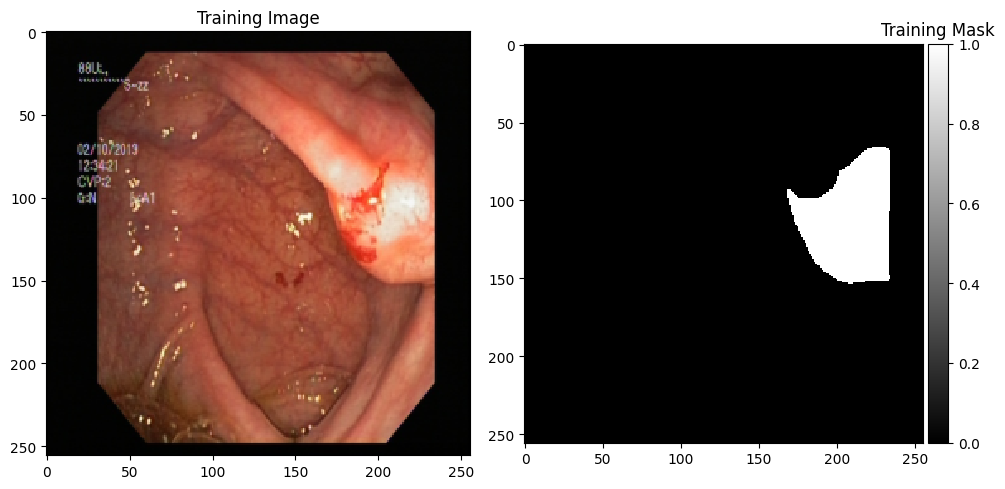

In [ ]:
import os
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define dataset paths
image_dir = '/kaggle/input/polypdb/PolypDB/PolypDB_modality_wise/WLI/images'
mask_dir = '/kaggle/input/polypdb/PolypDB/PolypDB_modality_wise/WLI/masks'

# Image parameters
IMG_HEIGHT, IMG_WIDTH = 256, 256
CHANNELS = 3
TARGET_SIZE = 15000  # Augmented dataset size

# Get sorted file lists
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Check image-mask consistency
if len(image_files) != len(mask_files):
    print(f"Warning: Image-mask count mismatch. Images: {len(image_files)}, Masks: {len(mask_files)}")
else:
    print(f"Found {len(image_files)} image-mask pairs.")

def load_and_preprocess(index):
    """Load, resize, and preprocess an image-mask pair."""
    image_path = os.path.join(image_dir, image_files[index])
    mask_path = os.path.join(mask_dir, mask_files[index])

    image = imread(image_path)
    mask = imread(mask_path, as_gray=True)

    # Ensure correct shape (for RGBA images)
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='reflect', anti_aliasing=True)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='reflect', anti_aliasing=True)

    # Convert mask to binary
    mask = (mask > 0.5).astype(np.uint8)

    return (image * 255).astype(np.uint8), mask

# Allocate arrays
aug_x_train = np.zeros((TARGET_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8)
aug_y_train = np.zeros((TARGET_SIZE, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

# Load images
for count in range(TARGET_SIZE):
    index = count % len(image_files)  # Cyclic repeat
    aug_x_train[count], aug_y_train[count, :, :, 0] = load_and_preprocess(index)

# Split dataset (70% train, 20% val, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(aug_x_train, aug_y_train, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

# Print dataset shapes
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")

# Display a sample
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(x_train[0])
plt.title("Training Image")
plt.subplot(1, 2, 2)
imshow(y_train[0, :, :, 0], cmap='gray')
plt.title("Training Mask")
plt.show()


In [ ]:
np.save("/kaggle/working/aug_x_train15000.npy", aug_x_train)
np.save("/kaggle/working/aug_y_train15000.npy", aug_y_train)


In [ ]:
from IPython.display import FileLink

# Generate a download link
FileLink('/kaggle/working/aug_x_train15000.npy')
#FileLink('/kaggle/working/aug_y_train15000.npy')


In [ ]:
import cv2
import os

# Set the output directory (Kaggle working directory)
output_dir = "/kaggle/working/augmented_data"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Assuming aug_x_train and aug_y_train are your augmented images and masks
for i in range(TARGET_SIZE):
    img_path = os.path.join(output_dir, f"image_{i}.png")
    mask_path = os.path.join(output_dir, f"mask_{i}.png")

    # Save augmented images and masks
    cv2.imwrite(img_path, aug_x_train[i])
    cv2.imwrite(mask_path, aug_y_train[i])


In [ ]:
print(f"Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")

Train: 10500, Val: 3000, Test: 1500


In [ ]:
print("X_train shape:", x_train.shape)  # (batch_size, 256, 256, 3)
print("y_train shape:", y_train.shape)  # Should be (batch_size, 256, 256, 1)


X_train shape: (10500, 256, 256, 3)
y_train shape: (10500, 256, 256, 1)


In [ ]:
IMG_SIZE=256

In [ ]:
def unet_resnet50(input_size=(IMG_SIZE, IMG_SIZE, 3)):

    base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=input_size)


    s1 = base_model.get_layer("conv1_relu").output  # Example layer, adjust as needed
    s2 = base_model.get_layer("conv2_block3_out").output  # Example layer, adjust as needed
    s3 = base_model.get_layer("conv3_block4_out").output  # Example layer, adjust as needed
    s4 = base_model.get_layer("conv4_block6_out").output  # Example layer, adjust as needed
    b5 = base_model.get_layer("conv5_block3_out").output  # Example layer, adjust as needed

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(b5)
    u6 = concatenate([u6, s4])
    c6 = Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, s3])
    c7 = Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, s2])
    c8 = Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, s1])
    c9 = Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    # Add another upsampling layer to reach 256x256
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c9)
    c10 = Conv2D(32, (3, 3), activation="relu", padding="same")(u10)
    c10 = Conv2D(32, (3, 3), activation="relu", padding="same")(c10)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c10)  # Output layer connected to u10

    return Model(inputs=base_model.input, outputs=outputs)


model = unet_resnet50()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 40,996,673 (156.39 MB)

 Trainable params: 40,943,553 (156.19 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
import tensorflow.keras.backend as K

smooth = 1

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)
# Create the metric objects outside the functions
prec = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    # Update states using the global metric objects
    prec.update_state(y_true, y_pred)
    rec.update_state(y_true, y_pred)

    p = prec.result()
    r = rec.result()

    # Reseting states for the next call
    prec.reset_state()
    rec.reset_state()

    return 2 * ((p * r) / (p + r + 1e-6))

def f2_score(y_true, y_pred):
    # Update states using the global metric objects
    prec.update_state(y_true, y_pred)
    rec.update_state(y_true, y_pred)

    p = prec.result()
    r = rec.result()

    # Reseting states for the next call
    prec.reset_state()
    rec.reset_state()

    return 5 * ((p * r) / ((4 * p) + r + 1e-6))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))  # Cast y_true to float32
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# In your model.compile call:
model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=[iou,dice_coef, f1_score, f2_score, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=7,            # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore best model weights
)

# Compile the model (assuming bce_dice_loss, iou, f1_score, etc., are defined)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=[iou, f1_score, f2_score, Precision(), Recall()])

# Train the model with Early Stopping
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=8,
    callbacks=[early_stopping]  # Add the Early Stopping callback
)


Epoch 1/30
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 282s 167ms/step - dice_coef: 0.6879 - f1_score: 0.6970 - f2_score: 0.6967 - iou: 0.5648 - loss: 0.4572 - precision_1: 0.7648 - recall_1: 0.6835 - val_dice_coef: 0.8700 - val_f1_score: 0.8763 - val_f2_score: 0.8337 - val_iou: 0.7762 - val_loss: 0.2204 - val_precision_1: 0.9683 - val_recall_1: 0.8010
Epoch 2/30
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 184s 140ms/step - dice_coef: 0.9113 - f1_score: 0.9209 - f2_score: 0.9201 - iou: 0.8401 - loss: 0.1343 - precision_1: 0.9310 - recall_1: 0.9169 - val_dice_coef: 0.9309 - val_f1_score: 0.9388 - val_f2_score: 0.9387 - val_iou: 0.8724 - val_loss: 0.1026 - val_precision_1: 0.9430 - val_recall_1: 0.9421
Epoch 3/30
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 184s 140ms/step - dice_coef: 0.9358 - f1_score: 0.9430 - f2_score: 0.9429 - iou: 0.8812 - loss: 0.0970 - precision_1: 0.9493 - recall_1: 0.9422 - val_dice_coef: 0.9395 - val_f1_score: 0.9463 - val_f2_score: 0.9490 - val_iou: 0.8875 - val_loss: 0.0896 - val_precision_1: 0.94

In [ ]:
y_pred = model.predict(x_test)  # Predict masks for test images


47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 339ms/step


In [ ]:
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)  # Convert probability map to binary mask


In [ ]:
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("y_pred_thresholded shape:", y_pred_thresholded.shape)


x_test shape: (1500, 256, 256, 3)
y_test shape: (1500, 256, 256, 1)
y_pred shape: (1500, 256, 256, 1)
y_pred_thresholded shape: (1500, 256, 256, 1)


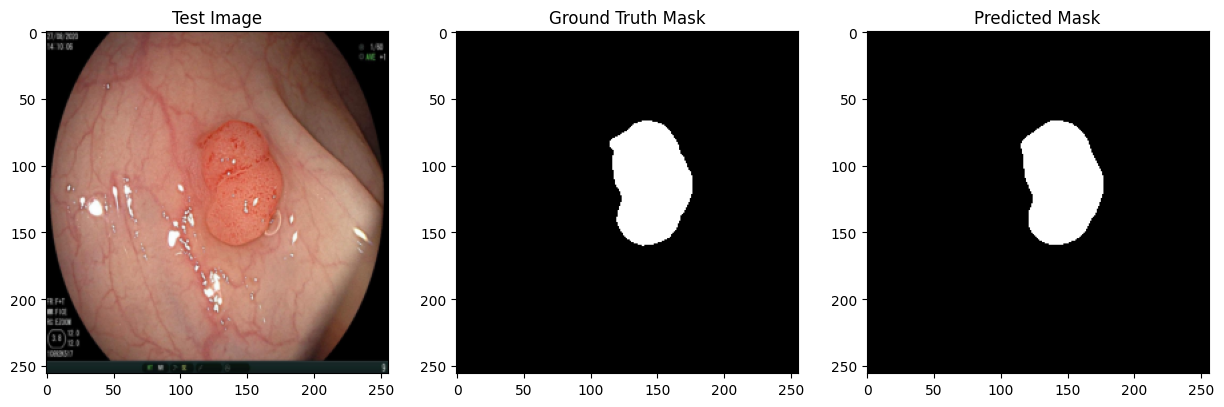

In [ ]:
import matplotlib.pyplot as plt
import random

# Select a random test image
index = random.randint(0, len(x_test) - 1)

plt.figure(figsize=(15, 5))

# Original test image
plt.subplot(1, 3, 1)
plt.imshow(x_test[index])
plt.title("Test Image")

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(y_test[index, :, :, 0], cmap='gray')
plt.title("Ground Truth Mask")

# Predicted mask (thresholded)
plt.subplot(1, 3, 3)
plt.imshow(y_pred_thresholded[index, :, :, 0], cmap='gray')
plt.title("Predicted Mask")

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

# Lists to store scores
dice_scores = []
iou_scores = []

# Initialize the Keras Precision and Recall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

# Loop through each test sample
for i in range(len(y_test)):
    # Convert to float32 before calculation
    y_true = y_test[i].astype(np.float32)
    y_pred = y_pred_thresholded[i].astype(np.float32)

    # Calculate Dice, IoU, Precision, and Recall for each sample
    dice = dice_coef(y_true, y_pred)
    iou_score = iou(y_true, y_pred)  # Assuming iou is your IoU function

    # Update the Precision and Recall metrics
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Append scores
    dice_scores.append(dice)
    iou_scores.append(iou_score)

# Final Precision and Recall after iterating through all test samples
mean_precision = precision_metric.result().numpy()
mean_recall = recall_metric.result().numpy()

# Calculate mean scores
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Compute F1 and F2 scores
if mean_precision + mean_recall > 0:
    f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)
    f2_score = 5 * (mean_precision * mean_recall) / (4 * mean_precision + mean_recall)
else:
    f1_score, f2_score = 0.0, 0.0  # Avoid division by zero

# Print results
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"F2 Score: {f2_score:.4f}")


Mean Dice Score: 0.9855
Mean IoU Score: 0.9724
Mean Precision: 0.9903
Mean Recall: 0.9915
F1 Score: 0.9909
F2 Score: 0.9913


In [ ]:
model.save("/kaggle/outputs/resnet50_unet.h5")  # Permanent save


In [ ]:
model.save("/kaggle/working/resnet50_unet.h5")  # Temporary save
